In [ ]:
import meshplot as mp
import numpy as np
import sys
import matplotlib.pyplot as plt
import json
import math
import igl
from matplotlib import pyplot as plt
sys.path.append("../src/")

# 1. Visualize Gradient

For a scalar value function $E$ using mesh vertices as variable (i.e, most of our energy function), 

we can visualize its gradient by drawing an arrow $\frac{\partial E}{\partial \boldsymbol{x}} $ at each of the mesh vertex $\boldsymbol{x}$, which help debug your code.

In [ ]:
def draw_mesh_and_gradient(V, F, G):
    fig = plt.figure()
    plt.triplot(V[:, 0], V[:, 1], triangles = F)
    plt.quiver(V[:, 0], V[:, 1], G[:, 0], G[:, 1])
    plt.axis('equal')
    plt.ylim([min(V[:, 1]) - 0.5, max(V[:, 1]) + 0.5])
    plt.show()    

## 1.1 Gradient of Mesh Area

In [ ]:
from energies import compute_faces_area_gradient, vertex_cells_sum
def compute_mesh_area_gradient(V, F):
    dAfx, dAfy = compute_faces_area_gradient(V, F)
    dAx = vertex_cells_sum(dAfx, F)
    dAy = vertex_cells_sum(dAfy, F)
    dA = np.column_stack([dAx, dAy])
    return dA

In [ ]:
V = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype = float)
F = np.array([[0, 1, 2], [1, 3, 2]])
G = compute_mesh_area_gradient(V, F)
draw_mesh_and_gradient(V, F, G)

In [ ]:
V = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [-1, 0, 0], [0, -1, 0]], dtype = float)
F = np.array([[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 1]])
G = compute_mesh_area_gradient(V, F)
draw_mesh_and_gradient(V, F, G)

Referenced image
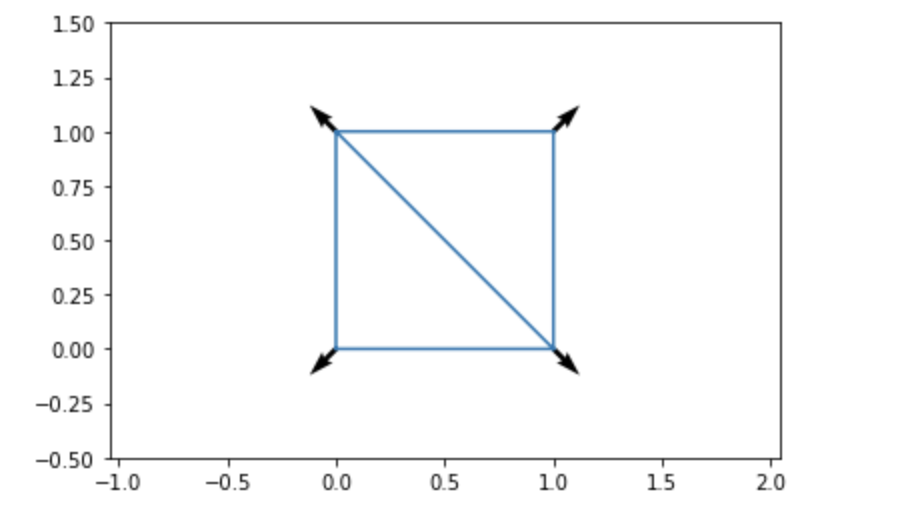
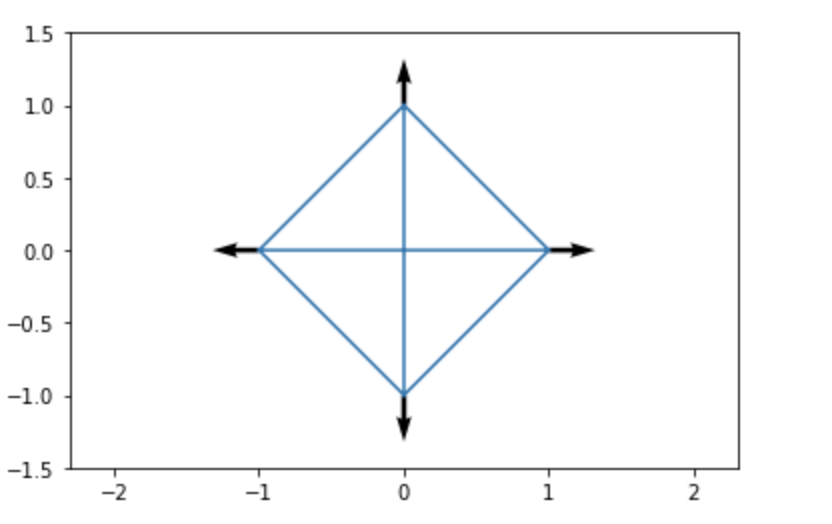

## 1.2 Gradient of Equilibrium Energy

In [ ]:
V = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype = float)
F = np.array([[0, 1, 2], [1, 3, 2]])
from energies import compute_equilibrium_energy_gradient
G = compute_equilibrium_energy_gradient(V, F, 0.0)
draw_mesh_and_gradient(V, F, G)

Referenced image
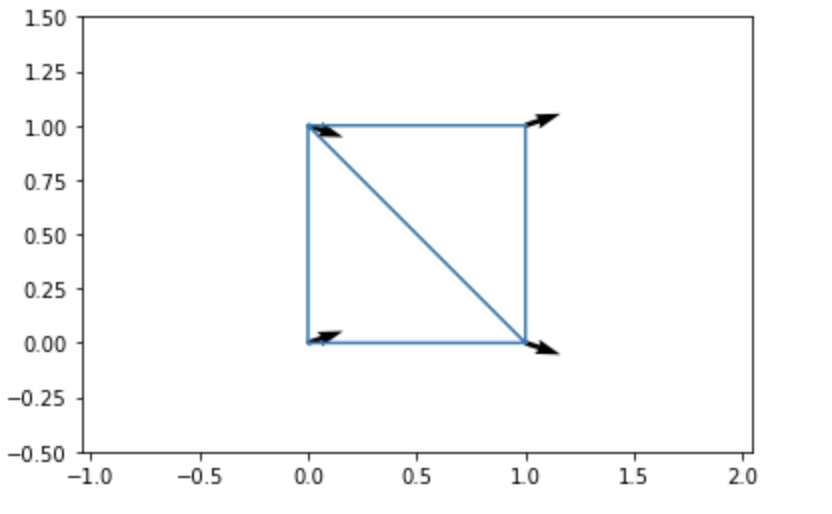

## 1.3 Gradient of Shape Energy

In [ ]:
V = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype = float)
F = np.array([[0, 1, 2], [1, 3, 2]])
E = igl.edges(F)
from energies import compute_shape_energy_gradient
G = compute_shape_energy_gradient(V, E, [0.0, 0.0, 0.0, 0.0, 0.0])
draw_mesh_and_gradient(V, F, G)

Referenced image
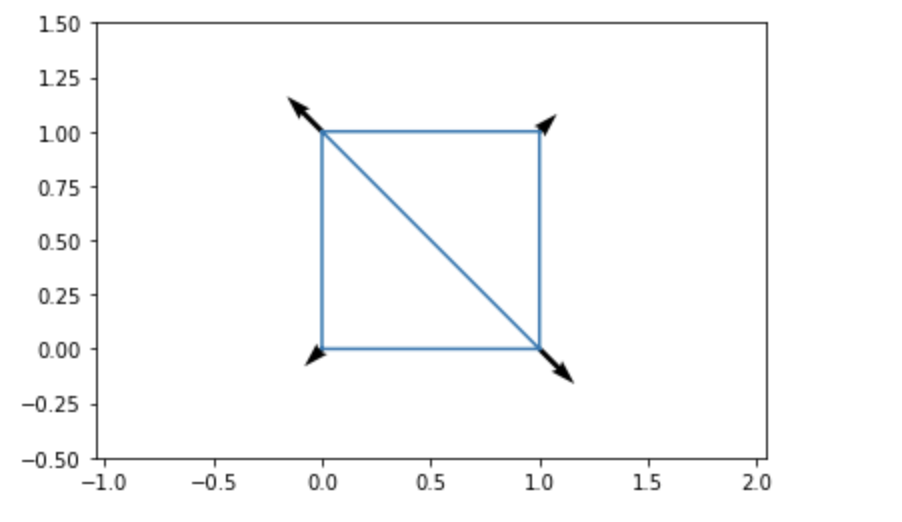

# 2. Analytical Gradient Compared with Finite Differences

Compare your hande written derivatives with the finite difference.

Given a function $f(\boldsymbol{x}), \boldsymbol{x} \in R^n$, because of the taylor expension, $f(\boldsymbol{x} + \boldsymbol{h}) = f(\boldsymbol{x}) + \nabla f(\boldsymbol{x})^T\boldsymbol{h} + o(\vert \vert \boldsymbol{h} \vert \vert)$

The finite difference at point $\boldsymbol{x}$ with step $\boldsymbol{h}$ is defined as $Df_h = f(\boldsymbol{x} + \boldsymbol{h}) - f(\boldsymbol{x})$

When $\vert \vert \boldsymbol{h} \vert \vert \rightarrow 0$, 

$$Err(f) = \frac{Df_h - \nabla f(\boldsymbol{x})^T\boldsymbol{h}}{\vert \vert \boldsymbol{h} \vert \vert} \rightarrow 0$$

We can draw the error graph $Err(f)$ by gradually deceasing the size of $\vert \vert \boldsymbol{h} \vert \vert$.

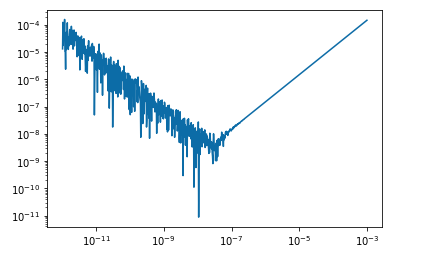

When $\vert \vert \boldsymbol{h} \vert \vert \leq 10^{-8}$, the percision of our computer is not enough to compute $Df_h$ correctly which causes the error grows significantly. All figures generated in this section should have this pattern (the absolute value does not matter), otherwise please check your derivatives.

In [ ]:
V = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0], [1, 1, 0]], dtype = float)
F = np.array([[0, 1, 2], [1, 3, 2]])
E = igl.edges(F)
deltaV = np.random.rand(V.shape[0], 2)
deltaV /= np.linalg.norm(deltaV)
scales = [math.pow(10, -x) for x in np.arange(3, 12.0, 0.01)]
def plot_finite_difference_errors(errors):
    fig = plt.figure()
    ax = fig.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.plot(scales, errors)

## 2.1 Mesh Area

In [ ]:
from geometry import compute_mesh_area

def compute_finite_difference_for_mesh_area(V, F, deltaV):
    V1 = V.copy()
    V1[:, 0 : 2] += deltaV
    finite_difference = compute_mesh_area(V1, F) - compute_mesh_area(V, F)
    return finite_difference

gradient = compute_mesh_area_gradient(V, F)
errors = []
for scale in scales:
    finite_difference = compute_finite_difference_for_mesh_area(V, F, deltaV * scale)
    analytical = gradient * deltaV * scale
    errors.append(abs(finite_difference - np.sum(analytical)) / scale)
plot_finite_difference_errors(errors)

## 2.2 Equilibrium Energy

In [ ]:
from energies import compute_equilibrium_energy
from energies import compute_equilibrium_energy_gradient


def compute_finite_difference_for_equilibrium_energy(V, F, x_csl, deltaV):
    V1 = V.copy()
    V1[:, 0 : 2] += deltaV
    return compute_equilibrium_energy(V1, F, x_csl) - compute_equilibrium_energy(V, F, x_csl)

x_csl = 0
gradient = compute_equilibrium_energy_gradient(V, F, x_csl)
errors = []
for scale in scales:
    finite_difference = compute_finite_difference_for_equilibrium_energy(V, F, x_csl, deltaV * scale)
    analytical = gradient * deltaV * scale
    errors.append(abs(finite_difference - np.sum(analytical)) / scale)
plot_finite_difference_errors(errors)

## 2.3 Shape Energy

In [ ]:
from energies import compute_shape_energy
from energies import compute_shape_energy_gradient
from energies import compute_edges_length

def compute_finite_difference_for_shape_energy(V, E, l0, deltaV):
    V1 = V.copy()
    V1[:, 0 : 2] += deltaV
    return compute_shape_energy(V1, E, l0) - compute_shape_energy(V, E, l0)

x_csl = 0
l0 = [0, 0, 0, 0, 0]
gradient = compute_shape_energy_gradient(V, E, l0)
errors = []
for scale in scales:
    finite_difference = compute_finite_difference_for_shape_energy(V, E, l0, deltaV * scale)
    analytical = gradient * deltaV * scale
    errors.append(abs(finite_difference - np.sum(analytical)) / scale)
plot_finite_difference_errors(errors)

# 3. Fixed Step Gradient Descent

In [ ]:
from geometry import compute_mesh_centroid

shader = {"flat":True, # Flat or smooth shading of triangles
           "wireframe": True, "wire_width": 0.03, "wire_color": "black", # Wireframe rendering
           "width": 600, "height": 600, # Size of the viewer canvas
           "antialias": True, # Antialising, might not work on all GPUs
           "scale": 2.0, # Scaling of the model
           "side": "DoubleSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
           "colormap": "viridis", "normalize": [None, None], # Colormap and normalization for colors
           "background": "#ffffff", # Background color of the canvas
           "line_width": 1.0, "line_color": "black", # Line properties of overlay lines
           "bbox": False, # Enable plotting of bounding box
           "point_color": "red", "point_size": 0.01 # Point properties of overlay points
          }

def draw_meshes_comparison(V1, F1, V2, F2, color1, color2):
    mesh_plot = mp.plot(V1, F1, c = color1, return_plot=True)
    mesh_plot.add_mesh(V2, F2, c = color2, shading=shader)
    
    center0 = np.array(compute_mesh_centroid(V2, F2))
    center1 = center0.copy()
    center1[1] = 0
    vertices = np.vstack([center0, center1])
    mesh_plot.add_points(vertices, shading={"point_color": "black", "point_size": 0.1})
    mesh_plot.add_edges(vertices, np.array([[0, 1]]), shading={"line_color": "black", "line_width" : 0.5});

# 3.1 Input Mesh

In [ ]:
with open('../data/dinosaur.json', 'r') as infile:
    [V, F] = json.load(infile)
    V = np.array(V)
    F = np.array(F)

# 3.2 Fixed Step Gradient Descent

In [ ]:
from optimization import fixed_step_gradient_descent
from geometry import compute_center_support_line

x_csl = compute_center_support_line(V)
[V1, F, objective, time] = fixed_step_gradient_descent(V, F, x_csl, w = 10, theta = 0.02, iters = 10000)

mesh_plot = draw_meshes_comparison(V, F, V1, F, np.array([0.3, 0.3, 0.3]), np.array([1.0, 1.0, 0]))

# 3.3 Draw Objective Energy Curve

In [ ]:
fig = plt.figure()
plt.plot(objective)
plt.xlabel("number of iteration")
plt.ylabel("objective energy")
plt.show()

## 3.4 Homework

Please optimize other meshes in the data/ folder to make them equilibrium. 

Simply copy the code above, change the input mesh and save the notebook as a pdf for submission.

Don't forgot to plot the objective energy curve.